## Demo: Feeder Concept
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

This notebook shows how to implement a basic feeder concept. This scenario has two vessels:
* *transporter01*: a vessel that transports the material from 'from_site', the source of the cargo, to 'to_site', the site where the cargo should be installed, and
* *installer01*: a vessel that waits at the installation site for material and installs it.

Thus, we also need two processes - one for each vessel. In this notebook the hand over of cargo is done from the *transporter01* to *installer01*.

NB1: in this example there are two types of cargo: Cargo_1 and Cargo_2. This means that the vessels and sites have to have multistore containers that can contain these different cargos. 

NB2: For now we only implemented the transport and installation process for Cargo_1. In fact only a quantity of one is shifted each cycle. THis needs to be extended still. The activities should furthermore be extended to include also Cargo_2. 

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasMultiContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.MultiContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {"key": "MultiStoreHopper"},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "store_capacity": 4,
                  "initials": [
                               {"id": "Cargo_1", "level": 5, "capacity": 10},
                               {"id": "Cargo_2", "level": 5, "capacity": 10},
                              ]
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "store_capacity": 4,
                "initials": [
                            {"id": "Cargo_1", "level": 0, "capacity": 5},
                            {"id": "Cargo_2", "level": 0, "capacity": 5},
                           ]
               }

# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [5]:
# prepare input data for transporter01
data_transporter01 = {"env": my_env,
                      "name": "transporter01",
                      "geometry": location_from_site, 
                      "loading_rate": 1,
                      "unloading_rate": 1,
                      "store_capacity": 4,
                      "compute_v": lambda x: 10,
                      "initials": [
                                   {"id": "Cargo_1", "level": 0, "capacity": 2},
                                   {"id": "Cargo_2", "level": 0, "capacity": 2},
                                  ],
                     }
# instantiate transporter01 
transporter01 = TransportProcessingResource(**data_transporter01)

# prepare input data for installer01
data_installer01 = {"env": my_env,
                    "name": "installer01",
                    "geometry": location_from_site, 
                    "loading_rate": 1,
                    "unloading_rate": 1,
                    "store_capacity": 4,
                    "compute_v": lambda x: 10,
                    "initials": [
                                 {"id": "Cargo_1", "level": 0, "capacity": 1},
                                 {"id": "Cargo_2", "level": 0, "capacity": 1},
                                ],
                   }
# instantiate installer01 
installer01 = TransportProcessingResource(**data_installer01)

##### 3.3 Create activity/activities

In [6]:
# initialise registry
registry = {}

###### 3.3.1 Create transporter activity

In [7]:
# create a list of the sub processes: transport to installation site
sub_processes =[
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=transporter01,
        destination=from_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="loading Cargo_1",
        registry=registry,
        processor=transporter01,
        origin=from_site,
        destination=transporter01,
        amount=1,
        duration=120,
        id_="Cargo_1",
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing filled",
        registry=registry,
        mover=transporter01,
        destination=to_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="transfer Cargo_1",
        registry=registry,
        processor=installer01,
        origin=transporter01,
        destination=installer01,
        amount=1,
        duration=120,
        id_="Cargo_1",
        start_event=[{"type": "activity", "name": "preparing for delivery", "state": "done",}],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
    env=my_env,
    name="sequential_activity_transport_subcycle",
    registry=registry,
    sub_processes=sub_processes,
)    

# create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
transport_activity = model.WhileActivity(
    env=my_env,
    name="Transporter01 move process",
    registry=registry,
    sub_processes=[sequential_activity],
    condition_event=[{"type": "container", "concept": from_site, "state": "empty", "id_": "Cargo_1"}],
)

###### 3.3.2 Create installer activity (first move, then install)

In [8]:
# create a list of the sub processes: in field installation
sub_processes =[
    model.BasicActivity(
        env=my_env,
        name="preparing for delivery",
        registry=registry,
        duration=30,
        additional_logs=[installer01],
    ),
    model.BasicActivity(
        env=my_env,
        name="preparing for unloading",
        registry=registry,
        duration=60,
        additional_logs=[installer01],
        start_event=[
            {"type": "activity", "name": "sequential_activity_transport_subcycle", "state": "done"}
        ],
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unload Cargo_1",
        registry=registry,
        processor=installer01,
        origin=installer01,
        destination=to_site,
        amount=1,
        duration=120,
        id_="Cargo_1",
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
installer_shift_sequential_activity = model.SequentialActivity(
    env=my_env,
    name="Installer01 installation process",
    registry=registry,
    sub_processes=sub_processes,
)

In [9]:
# create a list of the sub processes: in field installation
sub_processes = [
    model.MoveActivity(
        env=my_env,
        name="sailing to site",
        registry=registry,
        mover=installer01,
        destination=to_site,
    ),
    model.WhileActivity(
        env=my_env,
        name="installer run while",
        registry=registry,
        sub_processes=[installer_shift_sequential_activity],
        condition_event=[
            {"type": "container", "concept": to_site, "state": "full", "id_": "Cargo_1"}
        ],
    ),
]

installer_move_sequential_activity = model.SequentialActivity(
    env=my_env,
    name="Installer01 move process",
    registry=registry,
    sub_processes=sub_processes,
)

#### 4. Register processes and run simpy

In [10]:
model.register_processes([transport_activity, installer_move_sequential_activity])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [11]:
plot.get_log_dataframe(transporter01, [*model.get_subprocesses(transport_activity)])

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing empty,1970-01-01 00:00:00.000000,START,POINT (4.18055556 52.18664444),"{'Cargo_1': 0, 'Cargo_2': 0}"
1,sailing empty,1970-01-01 00:00:00.000000,STOP,POINT (4.18055556 52.18664444),"{'Cargo_1': 0, 'Cargo_2': 0}"
2,loading Cargo_1,1970-01-01 00:00:00.000000,START,POINT (4.18055556 52.18664444),"{'Cargo_1': 0, 'Cargo_2': 0}"
3,loading Cargo_1,1970-01-01 00:02:00.000000,STOP,POINT (4.18055556 52.18664444),"{'Cargo_2': 0, 'Cargo_1': 1}"
4,sailing filled,1970-01-01 00:02:00.000000,START,POINT (4.18055556 52.18664444),"{'Cargo_2': 0, 'Cargo_1': 1}"
5,sailing filled,1970-01-01 00:17:42.824591,STOP,POINT (4.25222222 52.11428333),"{'Cargo_2': 0, 'Cargo_1': 1}"
6,transfer Cargo_1,1970-01-01 00:17:42.824591,START,POINT (4.25222222 52.11428333),"{'Cargo_2': 0, 'Cargo_1': 1}"
7,transfer Cargo_1,1970-01-01 00:19:42.824591,STOP,POINT (4.25222222 52.11428333),"{'Cargo_2': 0, 'Cargo_1': 0}"
8,sailing empty,1970-01-01 00:19:42.824591,START,POINT (4.25222222 52.11428333),"{'Cargo_2': 0, 'Cargo_1': 0}"
9,sailing empty,1970-01-01 00:35:25.649183,STOP,POINT (4.18055556 52.18664444),"{'Cargo_2': 0, 'Cargo_1': 0}"


##### 5.2 Visualise gantt charts

In [12]:
plot.vessel_planning([*model.get_subprocesses(transport_activity), *model.get_subprocesses(installer_move_sequential_activity)])

##### 5.3 Visualise container volume developments

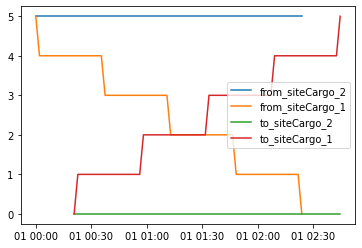

In [13]:
fig = plot.get_step_chart([from_site, to_site])

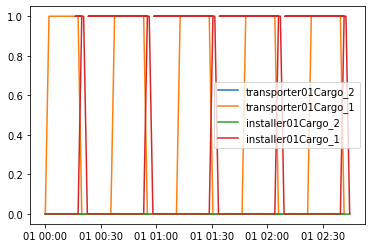

In [14]:
fig = plot.get_step_chart([transporter01, installer01])